# Preamble

In [354]:
import sys
#sys.path.insert(0, dir_notebook)

from my_units import *
from model_functions import * 
from load_functions import *
from yellin_functions import *

i_mock = 6 # mock file number
i_m = 91
list_m = np.arange(3,40,0.1)
m = list_m[i_m]  # axion mass [keV]
print(m)
k = 10 # number of bins

12.100000000000009


In [355]:
list_mu = np.logspace(0.2,2.11,201)

In [356]:
dir_home = '/mnt/home/kvantilburg/'
dir_ceph = dir_home+'ceph/LuminousBasin/'
dir_events = dir_ceph+'mocks/event_lists/'
dir_source = dir_ceph+'data/products_80610202001_orbit1_chu12_spatialARF/'
dir_production = dir_ceph+'data/production/'
dir_proj = dir_ceph+'yellin_projections/mocks/mock_'+str(i_mock)+'/'
dir_mc = dir_ceph+'yellin_vols/k10_1/'

# Get $\overline{C}_\mathrm{max}$

In [357]:
list_mu = np.logspace(0.2,2.11,201)[1:]
df_C_max_bar = pd.read_csv(dir_ceph+'yellin_vols/k10_1/vols_k10_cmax_bar.csv')
df_C_max_bar = df_C_max_bar[df_C_max_bar['mu'] !='mu']
df_C_max_bar = df_C_max_bar.astype('float')
df_C_max_bar.sort_values(by='mu',ignore_index=True,inplace=True)
err_frac = 1 / np.sqrt(df_C_max_bar['N_MC'] * (1-df_C_max_bar['C_max_bar']))
int_C_max_bar = interp1d(df_C_max_bar['mu'],df_C_max_bar['C_max_bar'],kind='linear',bounds_error=False,fill_value=1.0)
int_C_max_bar_2 = interp1d(df_C_max_bar['mu'],1-(1-2*err_frac)*(1-df_C_max_bar['C_max_bar']),kind='linear',bounds_error=False,fill_value=1.0)

# Set mu limit

In [358]:
file_proj = dir_proj+'proj/proj_'+str(i_mock)+'_'+str(i_m)+'_fid.csv'

df_proj = pd.read_csv(file_proj)
N_proj = len(df_proj)
i_down_max = np.max([0,np.int(np.ceil(np.log(N_proj/100)/np.log(2)))])
N_proj, i_down_max, N_proj * 2.0**(-i_down_max)

(10455, 7, 81.6796875)

In [359]:
for i_down in range(0,1+i_down_max):
    file_vol = dir_proj+'vols/vols_k'+str(k)+'_'+str(i_mock)+'_'+str(i_m)+'_d_'+f'{i_down:02d}'+'_fid.csv'
    df_vol = pd.read_csv(file_vol)
    vols = df_vol.iloc[0].to_numpy()
    
    try:
        i_mu_guess = np.argwhere(list_mu > 1.5 * len(df_vol.iloc[0]))[0][0] # guess smallest mu > 1.5 counts observed
        mu_guess = list_mu[i_mu_guess]
    except:
        i_mu_guess = len(list_mu)-1
        mu_guess = np.max(list_mu)
    print('i_down =',i_down,'| len(vols) =',len(vols),'| mu_guess =',mu_guess,'| i_mu_guess =',i_mu_guess)
    
    mu_lo = 0; C_max_lo = 0
    mu_hi = 1e4; C_max_hi = 1
    n_iter_max = 150
    n_iter = 0
    i_mu = i_mu_guess
    n_hi = 0
    n_lo = 0
    while (n_iter < n_iter_max) & ((n_lo < 0.5) or (n_hi < 0.5)):
        mu = list_mu[i_mu]
        print('n_iter =',n_iter,'|','mu =',mu)
        df = pd.read_csv(dir_mc+'vols_k10_imu_'+f'{i_mu:03d}'+'.csv',
                         names=['mu']+list(range(0,np.int(50+1.2*mu),1)),skiprows=[0]) #set no. of columns large
        df = df.replace(np.nan,1.0) #set all nan volumes to 1
        nunique = df.nunique()
        cols_to_drop = nunique[nunique == 1].index
        df = df.drop(cols_to_drop[1:], axis=1)
        
        vols_mc = df.to_numpy()[:,1:] #get volumes
        N = vols_mc.shape[0]
        list_C_n = np.zeros(np.min([len(vols),vols_mc.shape[1]]))
        for n in range(np.min([len(vols),vols_mc.shape[1]])):
            res = stats.cumfreq(vols_mc[:,n],numbins = 1001,defaultreallimits=(0,1))
            x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,res.cumcount.size)
            C_n = interp1d(x,res.cumcount/N)
            list_C_n[n] = C_n(vols[n])
        C_max = np.max(list_C_n);
 
        print('C_max =',C_max,'| C_max_bar =', int_C_max_bar_2(mu))
    
        if (n_iter==0) & (C_max < int_C_max_bar_2(mu)):
            print('downsampling needed')
            break
        
        if C_max >= int_C_max_bar_2(mu):
            mu_hi = mu
            C_max_hi = C_max
            print('hi')
            n_hi = 1
            n_lo = 0
        else:
            n_lo = 1
            mu_lo = mu
            C_max_lo = C_max
            print('lo')
            break
        i_mu = i_mu - 1
        n_iter += 1
    if (n_lo == 1) & (n_hi == 1):
        print('Iterative procedure converged.')
        break
N_sig_lim_yellin = mu_hi * (N_proj / (len(vols)-1))

i_down = 0 | len(vols) = 10456 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_iter = 0 | mu = 128.82495516931337
C_max = 0.0 | C_max_bar = 0.9982475788588597
downsampling needed
i_down = 1 | len(vols) = 5229 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_iter = 0 | mu = 128.82495516931337
C_max = 0.0 | C_max_bar = 0.9982475788588597
downsampling needed
i_down = 2 | len(vols) = 2615 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_iter = 0 | mu = 128.82495516931337
C_max = 0.0 | C_max_bar = 0.9982475788588597
downsampling needed
i_down = 3 | len(vols) = 1308 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_iter = 0 | mu = 128.82495516931337
C_max = 0.0 | C_max_bar = 0.9982475788588597
downsampling needed
i_down = 4 | len(vols) = 654 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_iter = 0 | mu = 128.82495516931337
C_max = 0.0 | C_max_bar = 0.9982475788588597
downsampling needed
i_down = 5 | len(vols) = 328 | mu_guess = 128.82495516931337 | i_mu_guess = 199
n_ite

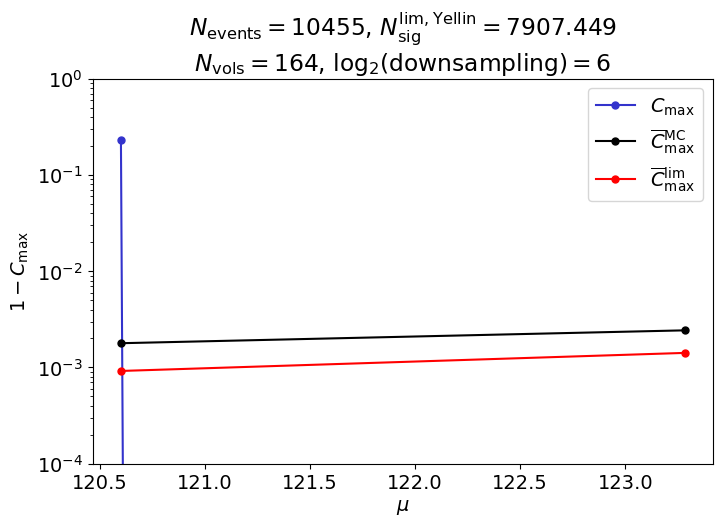

In [361]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([mu_lo,mu_hi],1-np.asarray([C_max_lo,C_max_hi]),color=(0.2,0.2,0.8),marker='.',markersize=10,label='$C_\mathrm{max}$');
ax.plot([mu_lo,mu_hi],1-int_C_max_bar(np.asarray([mu_lo,mu_hi])),color=(0,0,0),marker='.',markersize=10,label='$\overline{C}_\mathrm{max}^\mathrm{MC}$');
ax.plot([mu_lo,mu_hi],1-int_C_max_bar_2(np.asarray([mu_lo,mu_hi])),color=(1,0,0),marker='.',markersize=10,label='$\overline{C}_\mathrm{max}^\mathrm{lim}$');
ax.set_xlabel('$\mu$'); ax.set_ylabel('$1-C_\mathrm{max}$'); 
ax.set_title(r'$N_\mathrm{events} =$'+str(N_proj)+', $N_\mathrm{sig}^\mathrm{lim,Yellin} = $'
             +str(N_sig_lim_yellin)[0:8]+'\n'+'$N_\mathrm{vols} = $'+str(len(vols))+', $\log_2(\mathrm{downsampling}) =$'+str(i_down))
ax.set_yscale('log');
ax.set_ylim(1e-4,1e0)
ax.legend(loc='upper right');

In [292]:
df = pd.DataFrame(data = [[m,N_sig_lim_yellin,]], columns=['m','N_sig_lim_yellin'])
df

,m,N_sig_lim_yellin
0,15.0,19.440167
